In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import PIL
import os
import random
from pycocotools.coco import COCO
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Activation, Flatten, MaxPooling2D, Conv2D, Conv2DTranspose, concatenate, Input
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import utils
import keras_tuner as kt
import pickle

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2022-12-09 22:11:26.815108: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-09 22:11:27.930254: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/dist-packages/cv2/../../lib64:
2022-12-09 22:11:27.930446: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvrtc.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/dist-packages/cv2/../../lib64:
2022-12-09 22:11:27.930

Num GPUs Available:  1


In [2]:
NAME = "RUN-1"

In [3]:
from IPython.display import Video

Video("HD_bathroom.mp4")

In [12]:
## Load Video

video = cv2.VideoCapture("HD_bathroom.mp4")

vid_frames = []

while(video.isOpened()):
    ret, frame = video.read()
 
    if ret == True:
        frame = cv2.resize(frame, (256,256))
        # plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        frame = frame / 255.0
        vid_frames.append(frame)
    else:
        break

video.release()
cv2.destroyAllWindows()

In [5]:
## Build Model

def make_encoder(inputs, n_filters=32, dropout_rate=0.2, pooling=True):
    x = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='HeNormal')(inputs)
    x = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='HeNormal')(x)
  
    skip = BatchNormalization()(x, training=False)
    skip = Dropout(dropout_rate)(skip)

    if pooling:
        x = MaxPooling2D(pool_size = (2,2))(skip)
    else:
        x = skip

    return x, skip

def make_decoder(prev_layer_input, skip_layer_input, n_filters=32):
    up = Conv2DTranspose(n_filters, (3,3), strides=(2,2), padding='same')(prev_layer_input)
    merge = concatenate([up, skip_layer_input], axis=-1)
    x = Conv2D(n_filters, 3,activation='relu', padding='same', kernel_initializer='HeNormal')(merge)
    x = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='HeNormal')(x)
    return x

def make_unet(input_shape, n_filters=32, n_classes=10, blocks=4, dropout_rate=0.2):

    inputs = Input(input_shape)

    encoder_blocks = []

    x = make_encoder(inputs, n_filters, dropout_rate=dropout_rate, pooling=True)
    prev_input = x[0]
    encoder_blocks.append(x)

    for i in range(blocks):
        x = make_encoder(prev_input, n_filters * (2**(i + 1)), dropout_rate=dropout_rate, pooling=(i!=blocks-1))
        encoder_blocks.append(x)
        prev_input = x[0]

    for i in range(blocks - 1, -1, -1):
        x = make_decoder(prev_input, encoder_blocks[i][1], n_filters * (2**i))
        prev_input = x

    x = Conv2D(n_filters, 3, activation="relu", padding="same", kernel_initializer="he_normal")(x)
    x = Conv2D(n_classes, 1, padding="same")(x)

    model = Model(inputs=inputs, outputs=x)

    model.compile(optimizer=optimizers.Adam(), loss=losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

    return model

In [6]:
def build_model_hp(hp):
    blocks = hp.Int("blocks", min_value=4, max_value=6, step=1)
    n_filters = hp.Int("n_filters", min_value=32, max_value=128, step=32)
    dropout_rate = hp.Float("dropout_rate", min_value=0.0, max_value=0.5, step=0.1)
    return make_unet((256,256,3), n_filters=n_filters, blocks=blocks, dropout_rate=dropout_rate)

In [7]:
## Load Model

MAX_TRIALS = 200

tuner = kt.BayesianOptimization(
                    max_trials=MAX_TRIALS,
                    hypermodel=build_model_hp,
                    objective="val_accuracy",
                    overwrite=False,
                    directory=f"tuners/{NAME}",
                    project_name=f"{NAME}",)

tuner.search_space_summary(extended=True)

INFO:tensorflow:Reloading Oracle from existing project tuners/RUN-1/RUN-1/oracle.json


2022-12-09 08:41:01.785657: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-09 08:41:02.446529: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22285 MB memory:  -> device: 0, name: GeForce RTX 3090, pci bus id: 0000:c1:00.0, compute capability: 8.6


INFO:tensorflow:Reloading Tuner from tuners/RUN-1/RUN-1/tuner0.json
Search space summary
Default search space size: 3
blocks (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 6, 'step': 1, 'sampling': None}
n_filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}


In [8]:
model = tuner.get_best_models(1)[0]
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [9]:
## Predict

X = np.array(vid_frames)

y_pred = model.predict(X)

with open("preds.pickle", "wb") as outfd:
    pickle.dump(y_pred, outfd)

2022-12-09 08:41:24.076887: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100


102/102 [==============================] - 11s 65ms/step


2022-12-09 08:41:34.337764: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 8540651520 exceeds 10% of free system memory.


In [13]:
X = np.array(vid_frames)

In [3]:
with open("preds.pickle", "rb") as infd:
    y_pred = pickle.load(infd)

In [3]:
y_pred.shape

(3258, 256, 256, 10)

In [4]:
coco = COCO("annotations.json")

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [16]:
colors = [(0, 0, 0),
         (230, 25, 75),
         (145, 30, 180),
         (250, 190, 212),
         (0, 128, 128),
         (220, 190, 255),
         (255, 250, 200),
         (128, 0, 0),
         (170, 255, 195),
         (128, 128, 0),
         (255, 215, 180)]

{'id': 1, 'name': 'mirror', 'supercategory': ''}

mirror


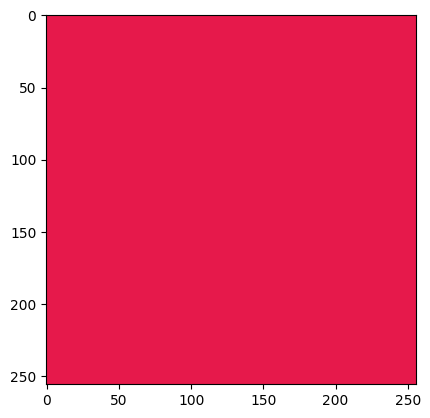

bathtub


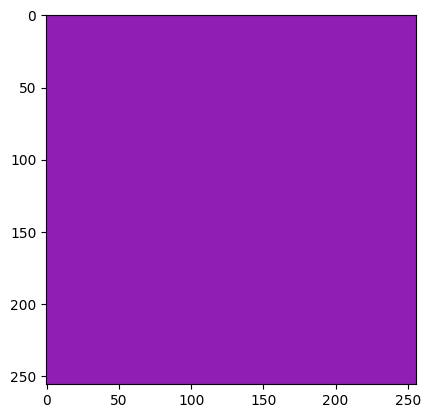

sink


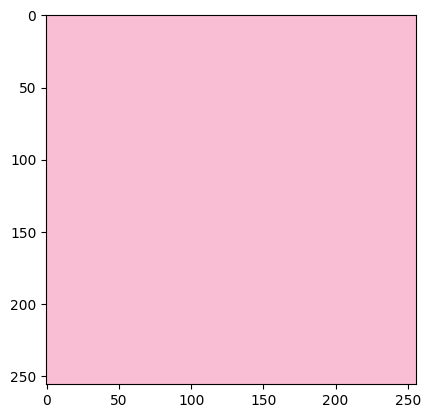

shelf


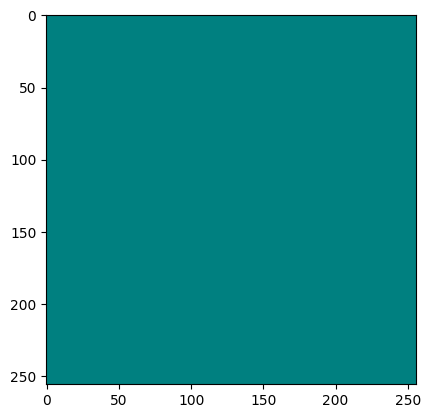

towel_bar


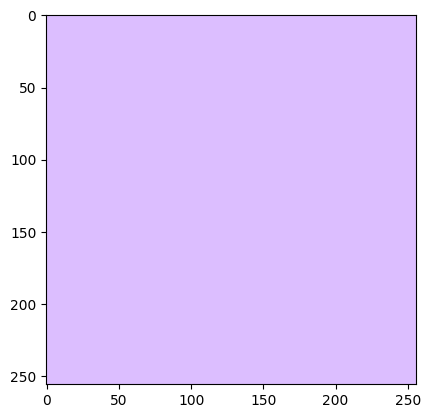

shower_curtain


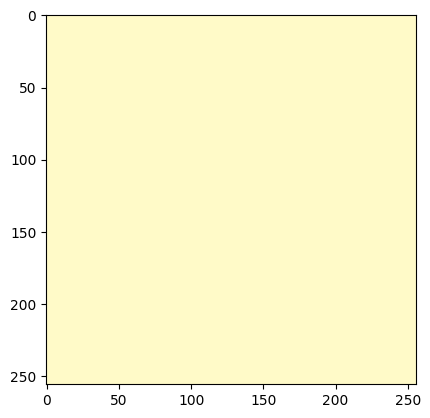

vanity


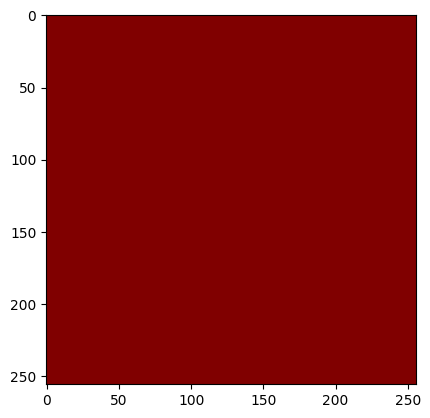

faucet


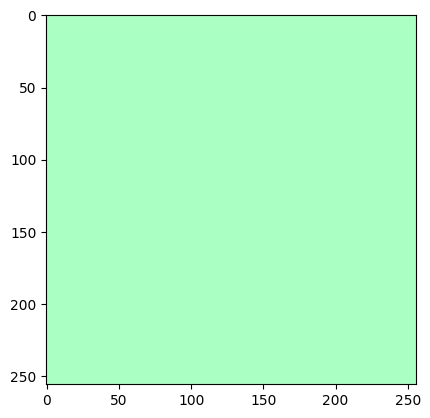

shower_head


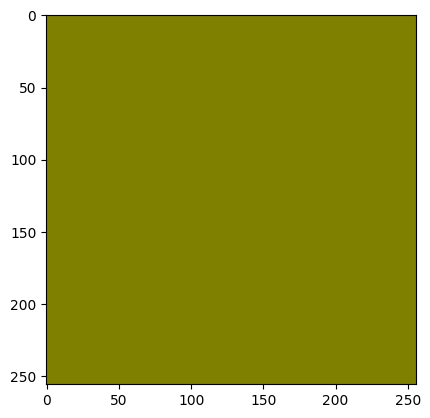

toilet


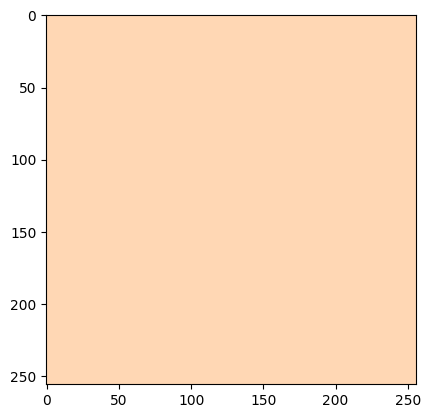

In [55]:
for c in coco.cats.keys():
    print(coco.cats[c]["name"])
    color_img = np.zeros((256,256,3))
    color_img = np.where(color_img, np.array(colors[coco.cats[c]["id"]]), np.array(colors[coco.cats[c]["id"]]))
    plt.imshow(color_img)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


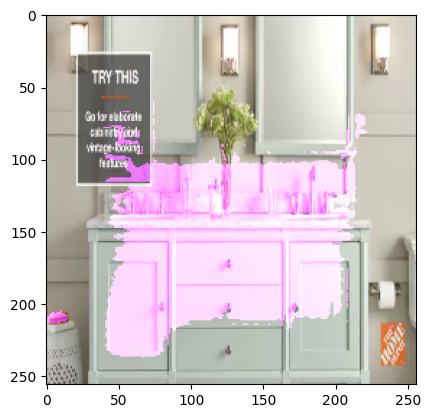

In [47]:
# plt.imshow(cv2.cvtColor((X[0] + np.argmax(y_pred[0], axis=-1) * 255, cv2.COLOR_BGR2RGB)))
idx = 900

img = cv2.cvtColor(np.array(X[idx]*255, dtype=np.uint8), cv2.COLOR_BGR2RGB)
# mask = np.argmax(y_pred[idx], axis=-1)
mask = cv2.cvtColor(np.array(np.argmax(y_pred[idx], axis=-1), dtype=np.uint8), cv2.COLOR_GRAY2RGB)

# mask = (mask * 16) + 64
# mask = np.where(mask == np.array([0, 0, 0]), np.array([0, 0, 0]), mask)
mask = np.where(mask != np.array([0, 0, 0]), np.array(colors[mask.max()]), mask)


# cv2.cvtColor(np.array(np.argmax(y_pred[idx], axis=-1)*100, dtype=np.uint8), cv2.COLOR_GRAY2RGB)

# frame =  - 
# plt.imshow(frame)
# coco.

mask
plt.imshow(np.where(mask > 0, mask + img, img))

In [61]:
vid_out = cv2.VideoWriter("HD_bathroom_seg.mp4", cv2.VideoWriter_fourcc(*'mp4v'), 25, (256, 256))

for i in tqdm(range(len(y_pred))):

    # img = cv2.cvtColor(np.array(X[i]*255, dtype=np.uint8), cv2.COLOR_BGR2RGB)
    img = np.array(X[i]*255, dtype=np.uint8)
    mask = cv2.cvtColor(np.array(np.argmax(y_pred[i], axis=-1), dtype=np.uint8), cv2.COLOR_GRAY2RGB)
    # mask = np.array(np.argmax(y_pred[i], axis=-1), dtype=np.uint8)

    # mask = np.where(mask != np.array([0, 0, 0]), np.array(colors[mask.max()]), mask)
    # mask = np.where(mask != np.array([0, 0, 0]), cv2.cvtColor(np.array(colors[mask.max()], dtype=np.uint8), cv2.COLOR_BGR2RGB), mask)
    mask = np.where(mask != np.array([0, 0, 0]), np.array(colors[mask.max()]), mask)
    
    seg_frame = np.where(mask > 0, mask + img, img)

    seg_frame = np.array(seg_frame, dtype=np.uint8)

    # plt.imshow(seg_frame)
    vid_out.write(seg_frame)

vid_out.release()
cv2.destroyAllWindows()

100%|██████████| 3258/3258 [00:18<00:00, 176.07it/s]
